# <font color='red'> CAMBIE NOMBRE DEL ARCHIVO

<font color='orange'> **ADVERTENCIA FINAL:** Este archivo debe llamarse "E08_[tu RUT].ipynb"
  
<font color='red'> **Ejemplo: E08_198765432.ipynb**

<font color='orange'> (el RUT debe ser sin puntos ni guion)

# Reconocimiento de Patrones
[Curso de Reconocimiento de Patrones](https://https://domingomery.ing.puc.cl/teaching/patrones/)

Departamento de Ciencia de la Computación

Universidad Catolica de Chile

(c) Domingo Mery, http://domingomery.ing.uc.cl



# Ejercicio 08: Estrategias para la Selección / Transformación de Características

En este ejercicio se realizará la clasificación de tumores (cancerígenos/no-cancerígenos) a partir de 1589 características extraídas de fotos endoscópicas a color del estómago. Las características corresponden a texturas de Haralick y Gabor en los distintos espacios de color.

La base de datos contiene 436 muestras (218 por clase) y 1589 características por muestra. En este ejemplo, se usarán por cada clase las primeras 200 para training y las otras 18 para testing.

**ADVERTENCIA:** Este ejercicio tiene fines pedagógicos sólamente, con la idea de que la solución a este problema pueda ejecutarse en un par de minutos. Un buen reconocedor automático sigue esta idea pero con miles de muestras por clase.

# Setup inicial

Liberías necesarias para que funcione el algoritmo.

## Instalación de Balu3

[Balu3](https://github.com/domingomery/balu3) es una librería creada para extraer y seleccionar características. 

In [1]:
#
# EJECUTAR ESTA CELDA SIN MODIFICARLA
#

!git clone https://github.com/domingomery/balu3
!pip install ./balu3

Cloning into 'balu3'...
remote: Enumerating objects: 261, done.
remote: Counting objects: 100% (261/261), done.
remote: Compressing objects: 100% (183/183), done.
remote: Total 261 (delta 152), reused 177 (delta 74), pack-reused 0
Receiving objects: 100% (261/261), 68.46 KiB | 1.43 MiB/s, done.
Resolving deltas: 100% (152/152), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./balu3
  Preparing metadata (setup.py) ... done
  Created wheel for balu3: filename=balu3-1.0-py3-none-any.whl size=43704 sha256=38b3cb77a5d33d705f85f4fc3597ac6edd898398015f98371103b5a43a12f6be
  Stored in directory: /tmp/pip-ephem-wheel-cache-4kdbcnex/wheels/9e/f6/a9/3d39da83a3504331129d706f5b04ceb3dbf0ec0f313cdb8fcf
Successfully built balu3


## Setup de librerías

In [2]:
#
# EJECUTAR ESTA CELDA SIN MODIFICARLA
#

import numpy                       as np
from   tqdm.auto                   import tqdm
from   balu3.fx.chr                import lbp
from   balu3.fs.sel                import jfisher,sfs,exsearch,clean
from   balu3.ft.trans              import pca
from   balu3.cl.basics             import SplitTrainTest # Separación entre training y testing
from   balu3.cl.basics             import ClassifierKNN  # Clasificación usando KNN
from   balu3.io.misc               import imageload
from   balu3.ft.norm               import minmax
from   sklearn.metrics             import confusion_matrix, accuracy_score
from   sklearn.decomposition       import FastICA
from   sklearn.cross_decomposition import PLSRegression
from   sklearn.neighbors           import KNeighborsClassifier
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from   mlxtend.feature_selection   import SequentialFeatureSelector as mlxsfs
print('Librerías cargadas.')

Librerías cargadas.


# Carga de base de datos

La base de datos consiste en 2 clases con 218 muestras por clase. Cada muestra tiene 1589 características. Al final de esta celda quedan definidias la matriz `X` de 436 x 1589 elementos y  los labels (ground truth, classificación ideal de cada muestra) en un vector `y` de 436 elementos (218 ceros y 218 unos).

In [3]:
#
# EJECUTAR ESTA CELDA SIN MODIFICARLA
#

!wget https://www.dropbox.com/s/icbjjw0mbmvyuwo/X_gender.npy
!wget https://www.dropbox.com/s/ns93v1bnet3tkj0/y_gender.npy

print('Base de datos cargada.')

X = np.load('X_gender.npy') # Características (matriz de 436 x 1589 elementos)
y = np.load('y_gender.npy') # Ground truth (labels) (vector de 436 elementos)
print('Características X: '+ str(X.shape)+ ' elementos.')
print('         Labels y: '+ str(y.shape)+ ' elementos.')

--2023-05-16 16:20:42--  https://www.dropbox.com/s/icbjjw0mbmvyuwo/X_gender.npy
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/icbjjw0mbmvyuwo/X_gender.npy [following]
--2023-05-16 16:20:42--  https://www.dropbox.com/s/raw/icbjjw0mbmvyuwo/X_gender.npy
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6ab1aaf3b5a14d5cb7700de91c.dl.dropboxusercontent.com/cd/0/inline/B8K4Ne05OVa7Tn15tS3mxH4kgnRqXs14wCdW5sUzruO_7cpu6B7tB3VupyepZUtGgzMnqNKRjKBOdviKHvqXJ5JWTEc1sFnRzGvqXcG_-_TstuGOjcpXd9wj2peBeibK7Adakn2rnyX7RjstnhNbXdBr6tIcMYYnNU-EG9rg2nt4Xw/file# [following]
--2023-05-16 16:20:43--  https://uc6ab1aaf3b5a14d5cb7700de91c.dl.dropboxusercontent.com/cd/0/inline/B8K4Ne05OVa7Tn15tS3mxH4kgnRqXs14wCdW5sUzruO_7cpu6B7tB3VupyepZUtGgzMnqNKRjKBOdvi

# Definición de Training y Testing

En todos los experimentos usaremos 200 muestras por clase para training y el resto (18) para testing. Para la separación train/test usaremos la función `SplitTrainTest`.

In [4]:
#
# EJECUTAR ESTA CELDA SIN MODIFICARLA
#

ntrain = 200
Xtrain,ytrain,Xtest,ytest = SplitTrainTest(X,y,ntrain)
print('muestras x características:')
print('Training: '+ str(Xtrain.shape))
print(' Testing: '+ str(Xtest.shape))


muestras x características:
Training: (400, 1589)
 Testing: (36, 1589)


# Clasificación con los datos originales (sin selección)

Para la clasificación usaremos siempre en todo el ejercicio la función `ClassifierKNN` con 5 vecinos sin normalizar, ya que los datos se normalizarán como un paso adicional.


In [5]:
#
# EJECUTAR ESTA CELDA SIN MODIFICARLA
#

vecinos    = 5
normalizar = False

acc0,C0 = ClassifierKNN(Xtrain,ytrain,Xtest,ytest,n_neighbors=vecinos,normalize=normalizar)

Entrenando con 400 muestras y probando con 36 muestras (de 1589 características)...
Testing Accuracy = 52.77777777777778%
Matriz de Confusión:
[[11  7]
 [10  8]]


# <font color='red'> ANTES DE SEGUIR..... CAMBIASTE EL NOMBRE DEL ARCHIVO DE ESTE COLAB?

*Seguir los pasos mostrados al inicio de este Colab*

# ESTRATEGIA DEL EJERCICIO

En este ejercicio se seguirá la estrategia mostrada en este diagrama. Por simplificación, se muestra sólo el nombre de las variables de training (obviamente en paralelo van los bloques del testing). En azul se indica el número de características (columnas) de cada variable. Cada bloque, numerado como 'Pj', es definido en la 'Pregunta j' del ejercicio.

ADVERTENCIA: Esta estrategia tiene sólo fines pedagógicos, probablemente una estrategia mucho más simple obtendría resultados similares. No creer por ningún motivo que esta estrategia necesariamente es una buena idea para el proyecto del curso, sin embargo, estrategias similares a esta (seguramente con menos bloques) podrían ser una buena solución.

<font color='red'>**AYUDA!**

<font color='orange'>Un ejemplo del uso de cada uno de estos bloques se encuentra en el Colab del ejemplo anterior. Para realizar este ejercicio se recomienda tener el ejemplo anterior abierto en otra ventana o pestaña. </font>

Colab de Ejemplo: [PAT03_SeleccionGeneral_new.ipynb](https://drive.google.com/file/d/1flNimfx35g0MdCAN3dbGmN_YshZ2UuKm)

# DIAGRAMA DE BLOQUES

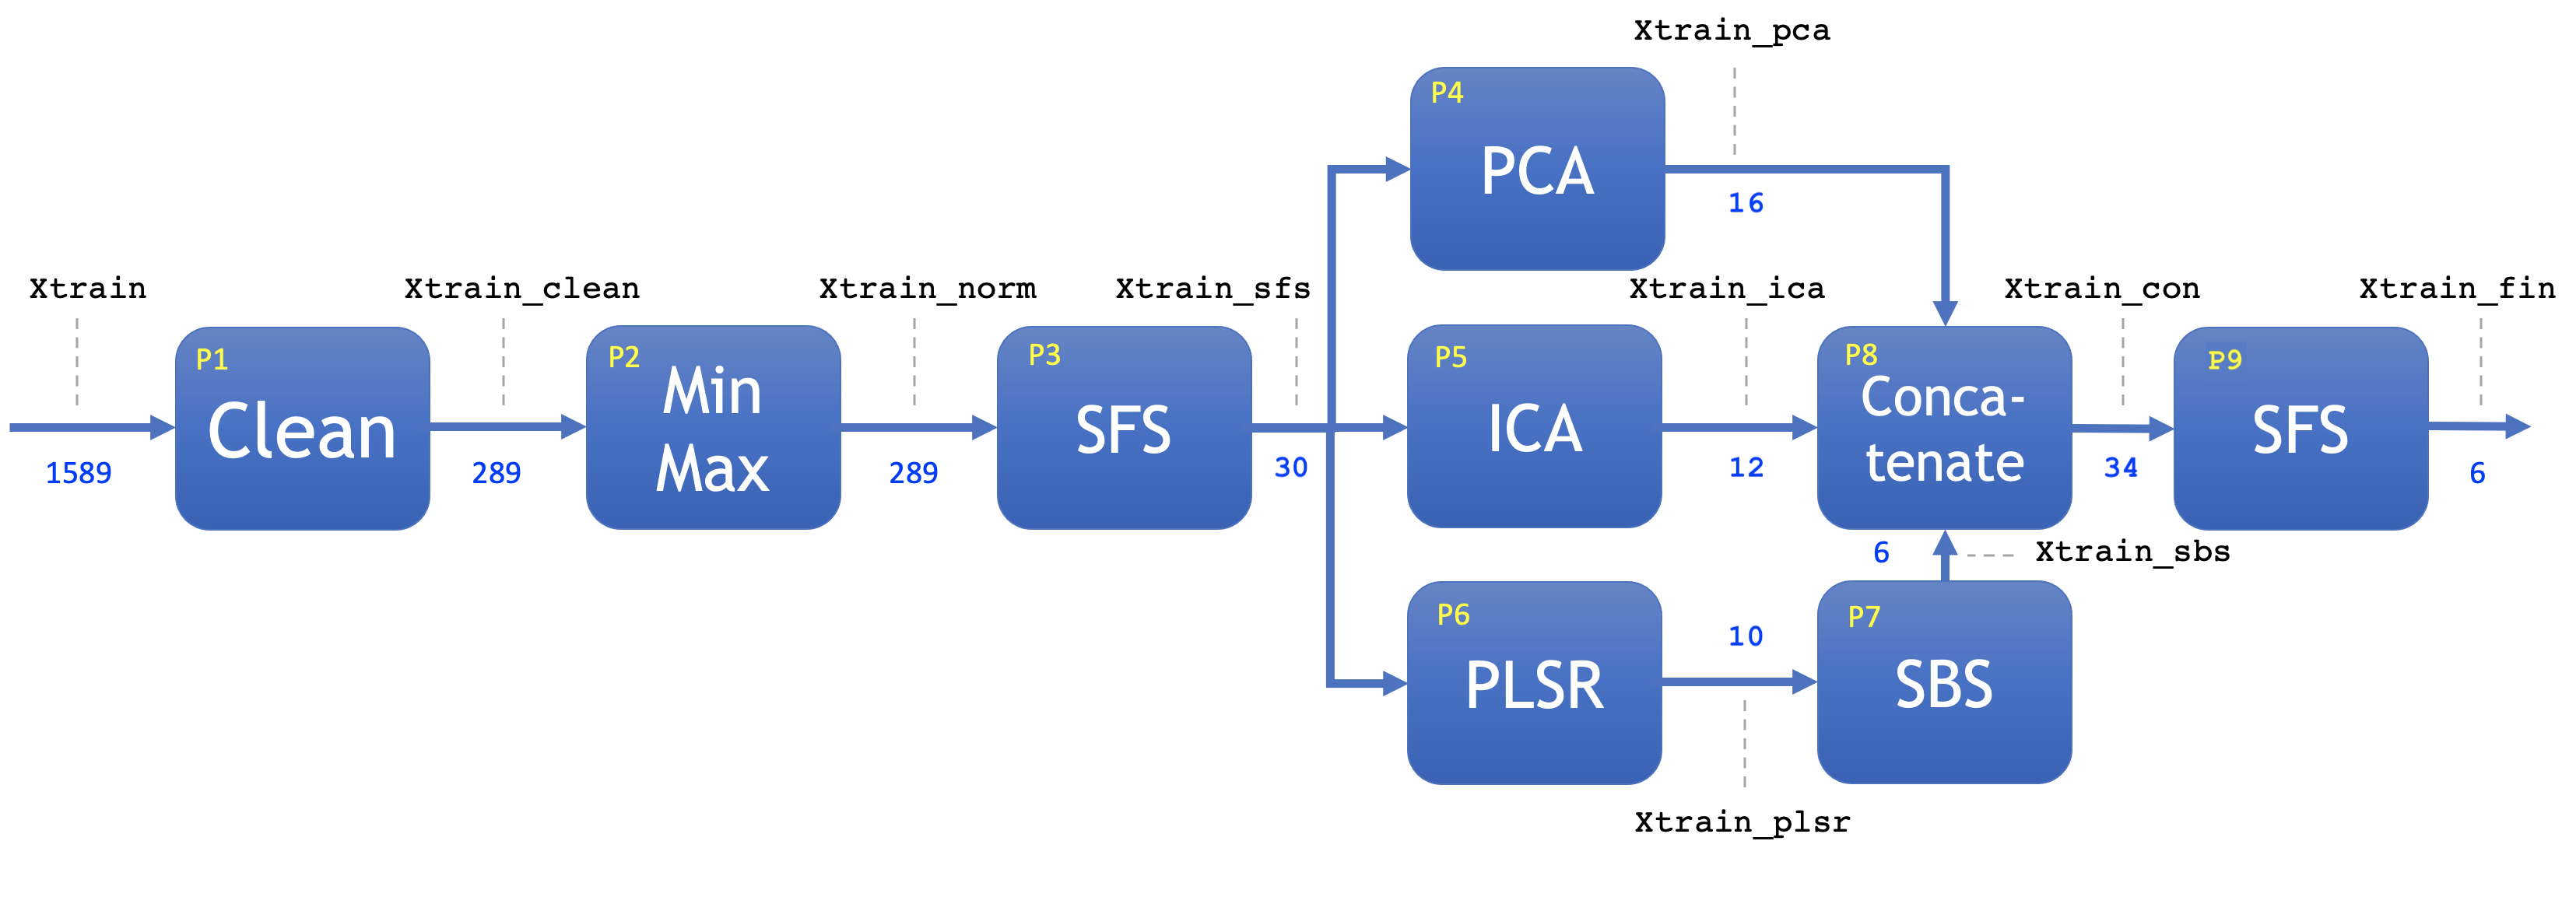

## ADVERTENCIA

<font color='red'> PARA LA EJECUCIÓN DE ESTA TAREA NO SE DEBE USAR OTRAS LIBRERÍAS 

(sólo está permitido usar las librerías definidas en las celdas anteriores)

<font color='orange'>Si tienes dudas de cómo se usan las funciones se recomienda ver la </font> <font color='red'>AYUDA </font> <font color='orange'>indicada más arriba </font>




# Pregunta P1: Clean

(1 punto)

<font color='red'> SIGUIENDO LA ESTRATEGIA DEL DIAGRAMA DE BLOQUES</font>... seleccione las características usando la función `clean` de Balu3.


In [6]:
# En ese código:
#    INPUT: Xtrain,Xtest
#    OUTPUT: Xtrain_clean,Xtest_clean
#    (también se debe calcular la matriz de confusión y el accuracy en el testing)

sclean       = clean(Xtrain)  # <= COMPLETAR AQUI índice de características seleccionadas
Xtrain_clean = Xtrain[:,sclean]  # <= COMPLETAR AQUI
Xtest_clean  = Xtest[:,sclean]  # <= COMPLETAR AQUI

# NO MODIFICAR LA SIGUIENTE LINEA
acc1,C1 = ClassifierKNN(Xtrain_clean,ytrain,Xtest_clean,ytest,n_neighbors=vecinos,normalize=normalizar)

Entrenando con 400 muestras y probando con 36 muestras (de 289 características)...
Testing Accuracy = 55.55555555555556%
Matriz de Confusión:
[[16  2]
 [14  4]]


# Pregunta P2: Normalización MinMax
(1 punto)

<font color='red'> SIGUIENDO LA ESTRATEGIA DEL DIAGRAMA DE BLOQUES</font>... normalice las características usando la función `MinMax` de Balu3.

In [7]:
# En ese código:
#    INPUT: Xtrain_clean,Xtest_clean
#    OUTPUT: Xtrain_norm,Xtest_norm
#    (también se debe calcular la matriz de confusión y el accuracy en el testing)

Xtrain_norm,a, b = minmax(Xtrain_clean) # <= COMPLETAR AQUI
Xtest_norm          = Xtest_clean * a + b # <= COMPLETAR AQUI

# NO MODIFICAR LA SIGUIENTE LINEA
acc2,C2 = ClassifierKNN(Xtrain_norm,ytrain,Xtest_norm,ytest,n_neighbors=vecinos,normalize=normalizar)

Entrenando con 400 muestras y probando con 36 muestras (de 289 características)...
Testing Accuracy = 72.22222222222221%
Matriz de Confusión:
[[12  6]
 [ 4 14]]


# Pregunta P3: Selección con SFS
(2 puntos)

<font color='red'> SIGUIENDO LA ESTRATEGIA DEL DIAGRAMA DE BLOQUES</font>...  selecciones las mejores 30 características usando `sfs` de `Balu3`.

In [8]:
# En ese código:
#    INPUT: Xtrain_norm, Xtest_norm
#    OUTPUT: Xtrain_sfs,Xtest_sfs
#    (también se debe calcular la matriz de confusión y el accuracy en el testing)

sel        = sfs(Xtrain_norm,ytrain,30,show=True) # <= COMPLETAR AQUI índice de características seleccionadas
Xtrain_sfs = Xtrain_norm[:,sel] # <= COMPLETAR AQUI 
Xtest_sfs  = Xtest_norm[:,sel] # <= COMPLETAR AQUI 

# NO MODIFICAR LA SIGUIENTE LINEA
acc3,C3 = ClassifierKNN(Xtrain_sfs,ytrain,Xtest_sfs,ytest,n_neighbors=vecinos,normalize=normalizar)

Selecting Features: 100%|██████████| 30.0/30.0 [00:10<00:00, 2.75 features/s]

Entrenando con 400 muestras y probando con 36 muestras (de 30 características)...
Testing Accuracy = 83.33333333333334%
Matriz de Confusión:
[[12  6]
 [ 0 18]]


# Pregunta P4: Transformación con PCA
(2 puntos)

<font color='red'> SIGUIENDO LA ESTRATEGIA DEL DIAGRAMA DE BLOQUES</font>... transforme las características usando `pca` de `Balu3` de tal forma que se obtengan las 16 componentes principales de PCA.


In [9]:
# En ese código:
#    INPUT: Xtrain_sfs, Xtest_sfs
#    OUTPUT: Xtrain_pca,Xtest_pca
#    (también se debe calcular la matriz de confusión y el accuracy en el testing)

Xtrain_pca, _, A, Xm, _ = pca(Xtrain_sfs, n_components=16)   # <= COMPLETAR AQUI
Xtest_pca                = np.matmul(Xtest_sfs - Xm, A)   # <= COMPLETAR AQUI

# NO MODIFICAR LA SIGUIENTE LINEA
acc4,C4 = ClassifierKNN(Xtrain_pca,ytrain,Xtest_pca,ytest,n_neighbors=vecinos,normalize=normalizar)

Entrenando con 400 muestras y probando con 36 muestras (de 16 características)...
Testing Accuracy = 83.33333333333334%
Matriz de Confusión:
[[12  6]
 [ 0 18]]


# Pregunta P5: Transformación con ICA
(2 puntos)

<font color='red'> SIGUIENDO LA ESTRATEGIA DEL DIAGRAMA DE BLOQUES</font>... trasnforme las características usando `ica` de `sklearn` de tal forma que se obtengan las 12 componentes principales de ICA.

In [10]:
# En ese código:
#    INPUT: Xtrain_sfs, Xtest_sfs
#    OUTPUT: Xtrain_ica,Xtest_ica
#    (también se debe calcular la matriz de confusión y el accuracy en el testing)

ica = FastICA(n_components=12, random_state=0)         # <= COMPLETAR AQUI la definición de ICA para 12 componentes
ica.fit(Xtrain_sfs, ytrain)  # <= COMPLETAR AQUI para calcular el ICA de Xtrain_sfs   

Xtrain_ica = ica.transform(Xtrain_sfs)  # <= COMPLETAR AQUI la transformación ICA de Xtrain_sfs
Xtest_ica  = ica.transform(Xtest_sfs)  # <= COMPLETAR AQUI la transformación ICA de Xtest_sfs

# NO MODIFICAR LA SIGUIENTE LINEA
acc5,C5 = ClassifierKNN(Xtrain_ica,ytrain,Xtest_ica,ytest,n_neighbors=vecinos,normalize=normalizar)

Entrenando con 400 muestras y probando con 36 muestras (de 12 características)...
Testing Accuracy = 91.66666666666666%
Matriz de Confusión:
[[16  2]
 [ 1 17]]


# Pregunta P6: Transformación con PLSR

<font color='red'> SIGUIENDO LA ESTRATEGIA DEL DIAGRAMA DE BLOQUES</font>... trasnforme las características usando `plsr` de `sklearn` de tal forma que obtengas las 10 componentes principales de PLSR.

In [11]:
# En ese código:
#    INPUT: Xtrain_sfs, Xtest_sfs
#    OUTPUT: Xtrain_plsr,Xtest_plsr
#    (también se debe calcular la matriz de confusión y el accuracy en el testing)


plsr = PLSRegression(n_components=10)            # <= COMPLETAR AQUI para definir PLSR con 10 componentes 
plsr.fit(Xtrain_sfs, ytrain) # <= COMPLETAR AQUI para calcular el PLSR de Xtrain_sfs  

Xtrain_plsr = plsr.transform(Xtrain_sfs) # <= COMPLETAR AQUI la transformación PLSR de Xtrain_sfs
Xtest_plsr  = plsr.transform(Xtest_sfs) # <= COMPLETAR AQUI la transformación PLSR de Xtest_sfs

# NO MODIFICAR LA SIGUIENTE LINEA
acc6,C6 = ClassifierKNN(Xtrain_plsr,ytrain,Xtest_plsr,ytest,n_neighbors=vecinos,normalize=normalizar)

Entrenando con 400 muestras y probando con 36 muestras (de 10 características)...
Testing Accuracy = 91.66666666666666%
Matriz de Confusión:
[[15  3]
 [ 0 18]]


# PREGUNTA P7: Selección con SBS
(2 puntos)

<font color='red'> SIGUIENDO LA ESTRATEGIA DEL DIAGRAMA DE BLOQUES</font>... selecciones las 6 mejores características usando `sbs` de `mlxtend`. 


En este ejemplo se debe usar como estimador:

`estimator = KNeighborsClassifier(n_neighbors=5)`

In [12]:
# En ese código:
#    INPUT: Xtrain_plsr, Xtest_plsr
#    OUTPUT: Xtrain_sbs,Xtest_sbs
#    (también se debe calcular la matriz de confusión y el accuracy en el testing)

# NO MODIFICAR LA SIGUIENTE LINEA
estimator = KNeighborsClassifier(n_neighbors=5)

p = 6                # <= COMPLETAR AQUI el número de características a seleccionar
forward = False          # <= COMPLETAR AQUI True para SFS y False para SBS

# NO MODIFICAR LA SIGUIENTE LINEA
sbs =   mlxsfs(estimator, k_features=p,forward=forward,floating=False,verbose=2,scoring='accuracy',cv=10)

sbs = sbs.fit(Xtrain_plsr, ytrain) # <= COMPLETAR AQUI para seleccionar las características de Xtrain_plsr 
sel = list(sbs.k_feature_idx_)        # <= COMPLETAR AQUI índice de características seleccionadas 

Xtrain_sbs = Xtrain_plsr[:,sel]       # <= COMPLETAR AQUI características seleccionadas de Xtrain_plsr
Xtest_sbs  = Xtest_plsr[:,sel]       # <= COMPLETAR AQUI características seleccionadas de Xtest_plsr

# NO MODIFICAR LA SIGUIENTE LINEA
acc7,C7 = ClassifierKNN(Xtrain_sbs,ytrain,Xtest_sbs,ytest,n_neighbors=vecinos,normalize=normalizar)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.0s finished

[2023-05-16 16:20:58] Features: 9/6 -- score: 0.85[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.6s finished

[2023-05-16 16:20:59] Features: 8/6 -- score: 0.8574999999999999[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.8s finished

[2023-05-16 16:20:59] Features: 7/6 -- score: 0.8400000000000001[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | e

Entrenando con 400 muestras y probando con 36 muestras (de 6 características)...
Testing Accuracy = 94.44444444444444%
Matriz de Confusión:
[[16  2]
 [ 0 18]]


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.5s finished

[2023-05-16 16:21:00] Features: 6/6 -- score: 0.8574999999999999

# PREGUNTA P8: Concatenación PCA, ICA y SBS
(1 punto)

<font color='red'> SIGUIENDO LA ESTRATEGIA DEL DIAGRAMA DE BLOQUES</font>...  realice la concatenación correspondiente. 

In [13]:
# En ese código:
#    INPUT: Xtrain_pca,Xtest_pca,Xtrain_ica,Xtest_ica,Xtrain_sbs,Xtest_sbs
#    OUTPUT: Xtrain_con,Xtest_con
#    (también se debe calcular la matriz de confusión y el accuracy en el testing)

Xtrain_con = np.concatenate((Xtrain_pca,Xtrain_ica,Xtrain_sbs),axis=1)   # <= COMPLETAR AQUI
Xtest_con  = np.concatenate((Xtest_pca,Xtest_ica,Xtest_sbs),axis=1)   # <= COMPLETAR AQUI

# NO MODIFICAR LA SIGUIENTE LINEA
acc8,C8 = ClassifierKNN(Xtrain_con,ytrain,Xtest_con,ytest,n_neighbors=vecinos,normalize=normalizar)

Entrenando con 400 muestras y probando con 36 muestras (de 34 características)...
Testing Accuracy = 94.44444444444444%
Matriz de Confusión:
[[16  2]
 [ 0 18]]


# PREGUNTA P9: SFS Final
(1 punto)

<font color='red'> SIGUIENDO LA ESTRATEGIA DEL DIAGRAMA DE BLOQUES</font>... selecciona las mejores 6 características usando `sfs` de `Balu3`.

In [14]:
# En ese código:
#    INPUT: Xtrain_con,Xtest_con
#    OUTPUT: Xtrain_fin,Xtest_fin
#    (también se debe calcular la matriz de confusión y el accuracy en el testing)

sel        = sfs(Xtrain_con,ytrain,6,show=True) # <= COMPLETAR AQUI  los índices de 6 características seleccionadas con sfs de Xtrain_con
Xtrain_fin = Xtrain_con[:,sel] # <= COMPLETAR AQUI las 30 columnas seccionadas de Xtrain_con
Xtest_fin  = Xtest_con[:,sel] # <= COMPLETAR AQUI las 30 columnas seccionadas de Xtest_con

# NO MODIFICAR LA SIGUIENTE LINEA
acc9,C9 = ClassifierKNN(Xtrain_fin,ytrain,Xtest_fin,ytest,n_neighbors=vecinos,normalize=normalizar)

Selecting Features: 100%|██████████| 6.00/6.00 [00:00<00:00, 30.9 features/s]

Entrenando con 400 muestras y probando con 36 muestras (de 6 características)...
Testing Accuracy = 100.0%
Matriz de Confusión:
[[18  0]
 [ 0 18]]


In [15]:
#
# EJECUTAR ESTA CELDA SIN MODIFICARLA
#

print('original: C = ',C0[0,:],C0[1,:],' | acc =',"{:6.2f}%".format(acc0*100),'features = |',Xtrain.shape[1])
print(' P01 out: C = ',C1[0,:],C1[1,:],' | acc =',"{:6.2f}%".format(acc1*100),'features = |',Xtrain_clean.shape[1])
print(' P02 out: C = ',C2[0,:],C2[1,:],' | acc =',"{:6.2f}%".format(acc2*100),'features = |',Xtrain_norm.shape[1])
print(' P03 out: C = ',C3[0,:],C3[1,:],' | acc =',"{:6.2f}%".format(acc3*100),'features = |',Xtrain_sfs.shape[1])
print(' P04 out: C = ',C4[0,:],C4[1,:],' | acc =',"{:6.2f}%".format(acc4*100),'features = |',Xtrain_pca.shape[1])
print(' P05 out: C = ',C5[0,:],C5[1,:],' | acc =',"{:6.2f}%".format(acc5*100),'features = |',Xtrain_ica.shape[1])
print(' P06 out: C = ',C6[0,:],C6[1,:],' | acc =',"{:6.2f}%".format(acc6*100),'features = |',Xtrain_plsr.shape[1])
print(' P07 out: C = ',C7[0,:],C7[1,:],' | acc =',"{:6.2f}%".format(acc7*100),'features = |',Xtrain_sbs.shape[1])
print(' P08 out: C = ',C8[0,:],C8[1,:],' | acc =',"{:6.2f}%".format(acc8*100),'features = |',Xtrain_con.shape[1])
print(' P09 out: C = ',C9[0,:],C9[1,:],' | acc =',"{:6.2f}%".format(acc9*100),'features = |',Xtrain_fin.shape[1])


original: C =  [11  7] [10  8]  | acc =  52.78% features = | 1589
 P01 out: C =  [16  2] [14  4]  | acc =  55.56% features = | 289
 P02 out: C =  [12  6] [ 4 14]  | acc =  72.22% features = | 289
 P03 out: C =  [12  6] [ 0 18]  | acc =  83.33% features = | 30
 P04 out: C =  [12  6] [ 0 18]  | acc =  83.33% features = | 16
 P05 out: C =  [16  2] [ 1 17]  | acc =  91.67% features = | 12
 P06 out: C =  [15  3] [ 0 18]  | acc =  91.67% features = | 10
 P07 out: C =  [16  2] [ 0 18]  | acc =  94.44% features = | 6
 P08 out: C =  [16  2] [ 0 18]  | acc =  94.44% features = | 34
 P09 out: C =  [18  0] [ 0 18]  | acc = 100.00% features = | 6


# VERIFICACION FINAL

<font color='red'> **ADVERTENCIA:** Este ejercicio será evaluado de la siguiente manera: si el código funciona y el resultado es correcto, la pregunta tendrá un 100% de la evaluación, en caso contrario 0%. Para asegurarse que el código se ejecute sin caídas seleccione la opción del menú:

1) <font color='orange'> 'Runtime' + 'Disconnect and delete runtime' (inicializa todo)

2) <font color='orange'> 'Run all'

<font color='red'> El código debería ejecutarse desde el inicio hasta el final sin problema alguno.

# PASO FINAL: Subir tarea

<font color='orange'> **ADVERTENCIA FINAL:** Este archivo, que debe llamarse "E08_[tu RUT].ipynb"
  
<font color='red'> **Ejemplo: E08_198765432.ipynb**

<font color='orange'> (el RUT debe ser sin puntos ni guion) y debe subirse a Canvas según la hora señalada para la actividad E08.